In [1]:
# Cell 1: Install and import required libraries
!pip install opencv-python matplotlib scikit-learn numpy pandas seaborn

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter
import requests
from io import BytesIO
from PIL import Image
import seaborn as sns
import pandas as pd

print("All libraries imported successfully!")


All libraries imported successfully!


## Gesture Detection

In [2]:
# Cell 2: Utility functions for image handling
def load_image_from_url(url):
    """Load image from URL"""
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

def load_image_from_upload():
    """Upload and load image from local system"""
    from google.colab import files
    uploaded = files.upload()
    for filename in uploaded.keys():
        img = cv2.imread(filename)
        return img
    return None

def display_images(original, processed=None, title1="Original", title2="Processed"):
    """Display original and processed images side by side"""
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2 if processed is not None else 1, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title(title1)
    plt.axis('off')

    if processed is not None:
        plt.subplot(1, 2, 2)
        if len(processed.shape) == 2:
            plt.imshow(processed, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
        plt.title(title2)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [3]:
# Cell 3: Basic Color Analysis using Histograms
def color_histogram_analysis(img, color_space='BGR'):
    """Analyze color distribution using histograms"""
    # Convert color space if needed
    if color_space == 'HSV':
        img_conv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        channels = ['Hue', 'Saturation', 'Value']
    elif color_space == 'LAB':
        img_conv = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        channels = ['L*', 'a*', 'b*']
    else:
        img_conv = img
        channels = ['Blue', 'Green', 'Red']

    # Create histogram plots
    plt.figure(figsize=(15, 5))
    colors = ['blue', 'green', 'red']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        hist = cv2.calcHist([img_conv], [i], None, [256], [0, 256])
        plt.plot(hist, color=colors[i])
        plt.title(f'{channels[i]} Channel Histogram')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

    return img_conv

In [4]:
# Cell 4: K-Means Clustering for Dominant Colors
def get_dominant_colors_kmeans(image, k=5, display=True):
    """
    Extract dominant colors using K-Means clustering
    """
    # Reshape image to be a list of pixels
    pixels = image.reshape(-1, 3)

    # Convert to float32 for K-Means
    pixels = np.float32(pixels)

    # Perform K-Means clustering
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 1.0)
    _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convert centers to uint8
    centers = np.uint8(centers)

    # Count labels to find dominant colors
    label_counts = Counter(labels.flatten())

    # Get dominant colors sorted by frequency
    total_pixels = len(labels)
    dominant_colors = []

    for color_idx, count in label_counts.most_common():
        color = centers[color_idx]
        percentage = (count / total_pixels) * 100
        dominant_colors.append({
            'color_bgr': color,
            'color_rgb': color[::-1],  # Convert BGR to RGB
            'percentage': percentage
        })

    if display:
        display_dominant_colors(dominant_colors, k)

    return dominant_colors

def display_dominant_colors(dominant_colors, k):
    """Display dominant colors as a color palette"""
    plt.figure(figsize=(12, 2))

    # Create color bars
    for i, color_info in enumerate(dominant_colors):
        plt.subplot(1, k, i+1)

        # Create color swatch
        color_swatch = np.ones((100, 100, 3), dtype=np.uint8)
        color_swatch[:, :] = color_info['color_rgb']

        plt.imshow(color_swatch)
        plt.title(f'{color_info["percentage"]:.1f}%')
        plt.axis('off')

    plt.suptitle(f'Top {k} Dominant Colors')
    plt.tight_layout()
    plt.show()


In [5]:
# Cell 5: Advanced Color Analysis with Multiple Techniques
def comprehensive_color_analysis(image_path_or_url, k=5):
    """
    Comprehensive color analysis using multiple techniques
    """
    # Load image
    if image_path_or_url.startswith('http'):
        img = load_image_from_url(image_path_or_url)
    else:
        img = cv2.imread(image_path_or_url)

    if img is None:
        print("Error: Could not load image")
        return

    print(f"Image loaded successfully! Shape: {img.shape}")

    # Display original image
    display_images(img, title1="Original Image")

    # Color Histogram Analysis
    print("\n=== COLOR HISTOGRAM ANALYSIS ===")
    color_histogram_analysis(img, 'BGR')
    color_histogram_analysis(img, 'HSV')

    # K-Means Dominant Colors
    print("\n=== DOMINANT COLORS (K-MEANS) ===")
    dominant_colors = get_dominant_colors_kmeans(img, k=k)

    # Color Statistics
    print("\n=== COLOR STATISTICS ===")
    print_color_statistics(img, dominant_colors)

    return dominant_colors

def print_color_statistics(img, dominant_colors):
    """Print detailed color statistics"""
    # Convert to different color spaces
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    print("Average Colors:")
    print(f"  BGR: {np.mean(img, axis=(0,1)).astype(int)}")
    print(f"  RGB: {np.mean(img[:,:,::-1], axis=(0,1)).astype(int)}")
    print(f"  HSV: {np.mean(hsv_img, axis=(0,1)).astype(int)}")

    print("\nDominant Colors (RGB):")
    for i, color_info in enumerate(dominant_colors):
        rgb = color_info['color_rgb']
        print(f"  Color {i+1}: RGB{rgb} - {color_info['percentage']:.1f}%")


In [6]:
# Cell 6: Color Name Mapping
def get_color_name(rgb_color):
    """
    Map RGB color to approximate color name
    """
    r, g, b = rgb_color

    # Predefined color ranges
    color_ranges = {
        'Red': ((200, 0, 0), (255, 100, 100)),
        'Green': ((0, 150, 0), (100, 255, 100)),
        'Blue': ((0, 0, 150), (100, 100, 255)),
        'Yellow': ((200, 200, 0), (255, 255, 150)),
        'Orange': ((200, 100, 0), (255, 150, 50)),
        'Purple': ((100, 0, 100), (180, 100, 180)),
        'Pink': ((200, 100, 150), (255, 180, 200)),
        'Brown': ((100, 50, 0), (150, 100, 50)),
        'Gray': ((100, 100, 100), (180, 180, 180)),
        'Black': ((0, 0, 0), (50, 50, 50)),
        'White': ((200, 200, 200), (255, 255, 255)),
        'Cyan': ((0, 150, 150), (100, 255, 255))
    }

    for color_name, ((r_min, g_min, b_min), (r_max, g_max, b_max)) in color_ranges.items():
        if r_min <= r <= r_max and g_min <= g <= g_max and b_min <= b <= b_max:
            return color_name

    return 'Unknown'

In [7]:
# Cell 7: Enhanced Dominant Color Detection with Names
def enhanced_dominant_colors(image, k=6):
    """
    Enhanced dominant color detection with color names
    """
    dominant_colors = get_dominant_colors_kmeans(image, k=k, display=False)

    # Add color names
    for color_info in dominant_colors:
        color_info['color_name'] = get_color_name(color_info['color_rgb'])

    # Display results
    plt.figure(figsize=(15, 4))

    # Display original image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    # Display color palette with names
    plt.subplot(1, 2, 2)
    for i, color_info in enumerate(dominant_colors):
        # Create color swatch
        color_swatch = np.ones((50, 200, 3), dtype=np.uint8)
        color_swatch[:, :] = color_info['color_rgb']

        plt.subplot(len(dominant_colors), 1, i+1)
        plt.imshow(color_swatch)
        plt.text(10, 25,
                f"{color_info['color_name']} - RGB{tuple(color_info['color_rgb'])} - {color_info['percentage']:.1f}%",
                fontsize=10, weight='bold', color='white' if np.mean(color_info['color_rgb']) < 128 else 'black')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Print detailed information
    print("\n=== ENHANCED COLOR ANALYSIS ===")
    for i, color_info in enumerate(dominant_colors):
        print(f"{i+1}. {color_info['color_name']}:")
        print(f"   RGB: {tuple(color_info['color_rgb'])}")
        print(f"   Percentage: {color_info['percentage']:.1f}%")
        print()

    return dominant_colors

In [8]:
# Cell 8: Main Execution and Examples
def main():
    """
    Main function to demonstrate color detection
    """
    print("=== IMAGE COLOR DETECTION DEMO ===\n")

    # Example 1: Load from URL
    print("Example 1: Loading image from URL")
    url = "https://images.unsplash.com/photo-1541963463532-d68292c34b19?ixlib=rb-1.2.1&auto=format&fit=crop&w=500&q=60"

    try:
        # Comprehensive analysis
        dominant_colors = comprehensive_color_analysis(url, k=6)

        # Enhanced analysis with color names
        img = load_image_from_url(url)
        enhanced_dominant_colors(img, k=6)

    except Exception as e:
        print(f"Error with URL image: {e}")
        print("Trying local upload...")

        # Example 2: Upload local image
        print("\nExample 2: Upload local image")
        img = load_image_from_upload()
        if img is not None:
            enhanced_dominant_colors(img, k=6)
        else:
            print("No image uploaded")

=== IMAGE COLOR DETECTION DEMO ===

Example 1: Loading image from URL
Image loaded successfully! Shape: (749, 500, 3)


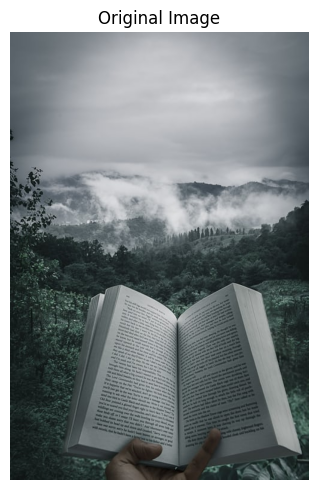


=== COLOR HISTOGRAM ANALYSIS ===


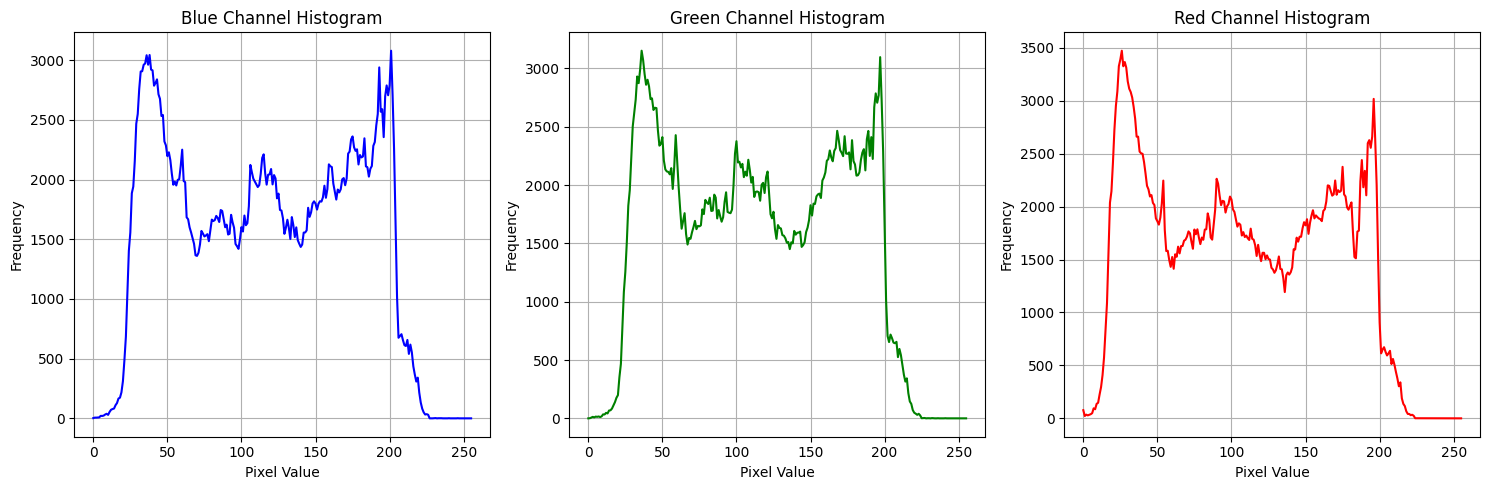

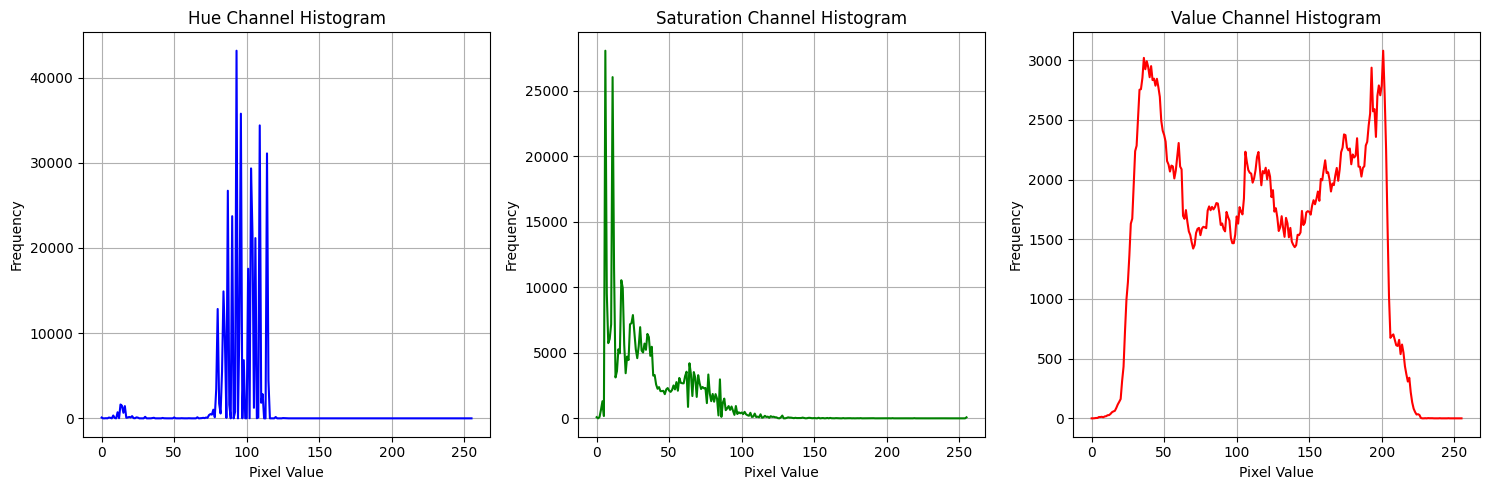


=== DOMINANT COLORS (K-MEANS) ===


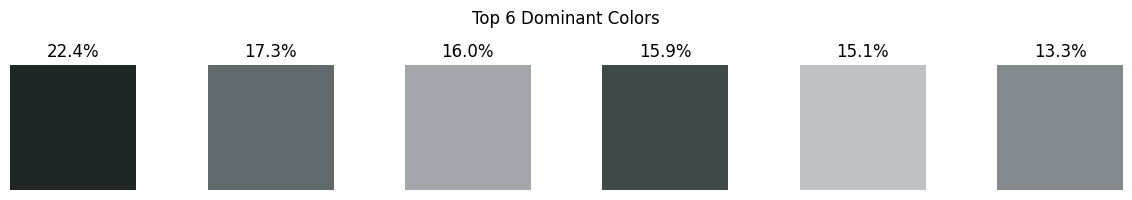


=== COLOR STATISTICS ===
Average Colors:
  BGR: [115 113 105]
  RGB: [105 113 115]
  HSV: [ 95  34 116]

Dominant Colors (RGB):
  Color 1: RGB[30 39 38] - 22.4%
  Color 2: RGB[ 96 106 109] - 17.3%
  Color 3: RGB[163 167 171] - 16.0%
  Color 4: RGB[62 73 73] - 15.9%
  Color 5: RGB[191 193 197] - 15.1%
  Color 6: RGB[131 138 142] - 13.3%


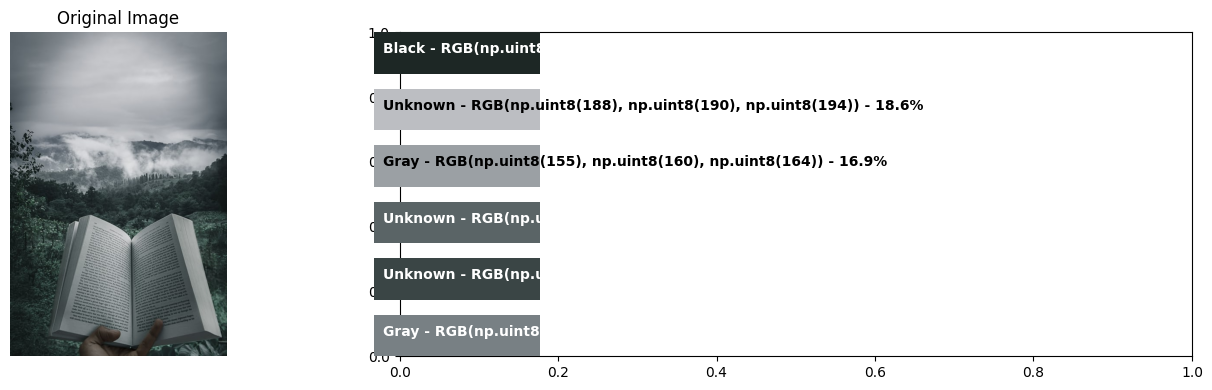


=== ENHANCED COLOR ANALYSIS ===
1. Black:
   RGB: (np.uint8(29), np.uint8(39), np.uint8(37))
   Percentage: 21.3%

2. Unknown:
   RGB: (np.uint8(188), np.uint8(190), np.uint8(194))
   Percentage: 18.6%

3. Gray:
   RGB: (np.uint8(155), np.uint8(160), np.uint8(164))
   Percentage: 16.9%

4. Unknown:
   RGB: (np.uint8(90), np.uint8(100), np.uint8(102))
   Percentage: 15.1%

5. Unknown:
   RGB: (np.uint8(58), np.uint8(69), np.uint8(69))
   Percentage: 14.6%

6. Gray:
   RGB: (np.uint8(120), np.uint8(128), np.uint8(132))
   Percentage: 13.6%



In [9]:
# Cell 9: Run the main function
if __name__ == "__main__":
    main()

In [16]:
# @title FIXED: Additional Utility - Background Color Detection
def detect_background_color(image, border_percentage=10):
    """
    Detect background color by analyzing image borders - FIXED VERSION
    """
    h, w = image.shape[:2]

    # Define border regions
    border_size_h = int(h * border_percentage / 100)
    border_size_w = int(w * border_percentage / 100)

    # Extract border regions and reshape ALL to 2D arrays (FIX APPLIED HERE)
    top_border = image[:border_size_h, :].reshape(-1, 3)
    bottom_border = image[h-border_size_h:, :].reshape(-1, 3)
    left_border = image[:, :border_size_w].reshape(-1, 3)
    right_border = image[:, w-border_size_w:].reshape(-1, 3)

    # Combine all borders (now all are 2D arrays with same dimensions)
    borders = np.vstack([top_border, bottom_border, left_border, right_border])

    # Find dominant color in borders
    dominant_bg_colors = get_dominant_colors_kmeans(borders, k=3, display=False)

    # The most dominant color in borders is likely the background
    background_color = dominant_bg_colors[0]
    background_color['color_name'] = get_color_name(background_color['color_rgb'])

    print("=== BACKGROUND COLOR ANALYSIS ===")
    print(f"Background Color: {background_color['color_name']}")
    print(f"RGB: {tuple(background_color['color_rgb'])}")
    print(f"Confidence: {background_color['percentage']:.1f}%")

    return background_color

In [17]:
# Cell 11: Test background detection
def test_background_detection():
    """Test background color detection"""
    url = "https://images.unsplash.com/photo-1579546929662-711aa81148cf?ixlib=rb-1.2.1&auto=format&fit=crop&w=500&q=60"
    img = load_image_from_url(url)
    display_images(img, title1="Test Image for Background Detection")
    detect_background_color(img)

# Uncomment to test background detection
# test_background_detection()


In [18]:
# Cell 12: Color Harmony Analysis
def analyze_color_harmony(dominant_colors):
    """
    Analyze color harmony based on dominant colors
    """
    print("\n=== COLOR HARMONY ANALYSIS ===")

    color_names = [color['color_name'] for color in dominant_colors]
    unique_colors = set(color_names)

    # Basic harmony analysis
    warm_colors = {'Red', 'Orange', 'Yellow', 'Pink'}
    cool_colors = {'Blue', 'Green', 'Purple', 'Cyan'}
    neutral_colors = {'Black', 'White', 'Gray', 'Brown'}

    warm_count = len(unique_colors & warm_colors)
    cool_count = len(unique_colors & cool_colors)
    neutral_count = len(unique_colors & neutral_colors)

    print(f"Warm colors: {warm_count}")
    print(f"Cool colors: {cool_count}")
    print(f"Neutral colors: {neutral_count}")

    if warm_count > cool_count and warm_count > neutral_count:
        print("Overall: Warm Color Palette")
    elif cool_count > warm_count and cool_count > neutral_count:
        print("Overall: Cool Color Palette")
    elif neutral_count >= warm_count and neutral_count >= cool_count:
        print("Overall: Neutral Color Palette")
    else:
        print("Overall: Mixed Color Palette")

    # Color contrast analysis
    if len(dominant_colors) >= 2:
        brightness_values = [np.mean(color['color_rgb']) for color in dominant_colors]
        contrast = max(brightness_values) - min(brightness_values)
        print(f"Color Contrast: {contrast:.1f}")

        if contrast > 150:
            print("Contrast Level: High")
        elif contrast > 100:
            print("Contrast Level: Medium")
        else:
            print("Contrast Level: Low")

In [19]:
# Cell 13: Complete Analysis Pipeline
def complete_color_analysis(image_source, k=6):
    """
    Complete color analysis pipeline
    """
    # Load image
    if isinstance(image_source, str) and image_source.startswith('http'):
        img = load_image_from_url(image_source)
    elif isinstance(image_source, str):
        img = cv2.imread(image_source)
    else:
        img = image_source

    if img is None:
        print("Error: Could not load image")
        return

    print("=== COMPLETE COLOR ANALYSIS ===")

    # 1. Basic image info
    print(f"Image Dimensions: {img.shape[1]} x {img.shape[0]}")

    # 2. Dominant colors with names
    dominant_colors = enhanced_dominant_colors(img, k=k)

    # 3. Background color
    bg_color = detect_background_color(img)

    # 4. Color harmony
    analyze_color_harmony(dominant_colors)

    # 5. Color statistics
    print_color_statistics(img, dominant_colors)

    return {
        'dominant_colors': dominant_colors,
        'background_color': bg_color,
        'image_shape': img.shape
    }

=== FINAL DEMONSTRATION ===
=== COMPLETE COLOR ANALYSIS ===
Image Dimensions: 500 x 750


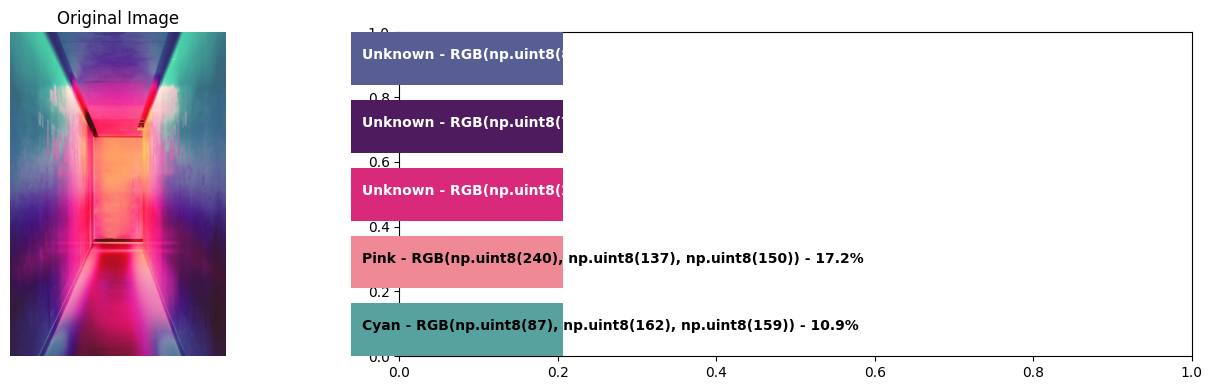


=== ENHANCED COLOR ANALYSIS ===
1. Unknown:
   RGB: (np.uint8(87), np.uint8(94), np.uint8(148))
   Percentage: 25.4%

2. Unknown:
   RGB: (np.uint8(77), np.uint8(27), np.uint8(94))
   Percentage: 25.0%

3. Unknown:
   RGB: (np.uint8(216), np.uint8(41), np.uint8(123))
   Percentage: 21.5%

4. Pink:
   RGB: (np.uint8(240), np.uint8(137), np.uint8(150))
   Percentage: 17.2%

5. Cyan:
   RGB: (np.uint8(87), np.uint8(162), np.uint8(159))
   Percentage: 10.9%

=== BACKGROUND COLOR ANALYSIS ===
Background Color: Unknown
RGB: (np.uint8(75), np.uint8(116), np.uint8(147))
Confidence: 53.1%

=== COLOR HARMONY ANALYSIS ===
Warm colors: 1
Cool colors: 1
Neutral colors: 0
Overall: Mixed Color Palette
Color Contrast: 109.7
Contrast Level: Medium
Average Colors:
  BGR: [130  81 138]
  RGB: [138  81 130]
  HSV: [128 157 169]

Dominant Colors (RGB):
  Color 1: RGB[ 87  94 148] - 25.4%
  Color 2: RGB[77 27 94] - 25.0%
  Color 3: RGB[216  41 123] - 21.5%
  Color 4: RGB[240 137 150] - 17.2%
  Color 5: RGB

In [20]:
# Cell 14: Final demonstration
print("=== FINAL DEMONSTRATION ===")

# Test with a sample image
sample_url = "https://images.unsplash.com/photo-1500462918059-b1a0cb512f1d?ixlib=rb-1.2.1&auto=format&fit=crop&w=500&q=60"
results = complete_color_analysis(sample_url, k=5)

print("\n=== ANALYSIS COMPLETE ===")